In [39]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# from Bio.Data import CodonTable
# from Bio.Data.CodonTable import NCBICodonTableDNA
# from Bio import SeqIO
from scipy import spatial

# from mutspec.annotation import (
#     calculate_mutspec, CodonAnnotation, mutations_summary, 
#     translator, rev_comp, lbl2lbl_id, lbl_id2lbl
# )
from mutspec_utils.constants import possible_codons, possible_sbs12, possible_sbs192
# from mutspec.io import read_genbank_ref
# from mutspec.draw.mut import plot_mutspec12, plot_mutspec192, plot_mutspec192kk

sns.set_style()

In [2]:
path_to_data = "../data/MutSpecVertebratescytb.csv"
mutspec = pd.read_csv(path_to_data)
print(mutspec.shape)
mutspec.head()

(187008, 10)


,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


## Drop species with low number of observed mutations!

In [3]:
sp_count = mutspec.groupby("Species").Observed.sum()

MIN_MUT_NUM = 50
mutspec = mutspec[mutspec.Species.isin(sp_count[sp_count > MIN_MUT_NUM].index)]
mutspec.shape[0]

115008

In [4]:
mutspec

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
192,Abbottina_rivularis,T[T>G]T,0.0,0.0,0.000000,67.375092,0.000000,T>G,TTT,Actinopterygii
193,Abbottina_rivularis,G[T>G]T,0.0,0.0,0.000000,67.375092,0.000000,T>G,GTT,Actinopterygii
194,Abbottina_rivularis,C[T>G]T,0.0,0.0,0.000000,67.375092,0.000000,T>G,CTT,Actinopterygii
195,Abbottina_rivularis,A[T>G]T,0.0,0.0,0.000000,67.375092,0.000000,T>G,ATT,Actinopterygii
196,Abbottina_rivularis,T[T>C]T,6.0,2.0,0.333333,67.375092,0.004947,T>C,TTT,Actinopterygii
...,...,...,...,...,...,...,...,...,...,...
187003,Zosterops_japonicus,A[A>G]A,3.0,3.0,1.000000,15.981840,0.062571,A>G,AAA,Aves
187004,Zosterops_japonicus,T[A>C]A,1.0,0.0,0.000000,15.981840,0.000000,A>C,TAA,Aves
187005,Zosterops_japonicus,G[A>C]A,5.0,0.0,0.000000,15.981840,0.000000,A>C,GAA,Aves
187006,Zosterops_japonicus,C[A>C]A,4.0,0.0,0.000000,15.981840,0.000000,A>C,CAA,Aves


In [63]:
sp2mut = mutspec.pivot(index=["Class", "Species"], columns="Mut", values="MutSpec")
sp2mut = sp2mut[possible_sbs192]
sp2mut.head()

Mut                                         A[A>C]A  A[A>C]C  A[A>C]G  \
Class          Species                                                  
Actinopterygii Abbottina_rivularis         0.000000      0.0      0.0   
               Acanthopagrus_schlegelii    0.010455      0.0      0.0   
               Acheilognathus_macropterus  0.002856      0.0      0.0   
               Acheilognathus_rhombeus     0.000000      0.0      0.0   
               Acheilognathus_signifer     0.006560      0.0      0.0   

Mut                                        A[A>C]T  C[A>C]A   C[A>C]C  \
Class          Species                                                  
Actinopterygii Abbottina_rivularis             0.0      0.0  0.000000   
               Acanthopagrus_schlegelii        0.0      0.0  0.000000   
               Acheilognathus_macropterus      0.0      0.0  0.000000   
               Acheilognathus_rhombeus         0.0      0.0  0.000000   
               Acheilognathus_signifer         0.0      0.0  0.008747   

Mut                                         C[A>C]G  C[A>C]T  G[A>C]A  \
Class          Species                                                  
Actinopterygii Abbottina_rivularis         0.000000      0.0  0.00000   
               Acanthopagrus_schlegelii    0.010455      0.0  0.00000   
               Acheilognathus_macropterus  0.000000      0.0  0.00000   
               Acheilognathus_rhombeus     0.000000      0.0  0.00000   
               Acheilognathus_signifer     0.000000      0.0  0.01312   

Mut                                        G[A>C]C  ...   C[T>G]G  C[T>G]T  \
Class          Species                              ...                      
Actinopterygii Abbottina_rivularis             0.0  ...  0.000000      0.0   
               Acanthopagrus_schlegelii        0.0  ...  0.007841      0.0   
               Acheilognathus_macropterus      0.0  ...  0.000000      0.0   
               Acheilognathus_rhombeus         0.0  ...  0.000000      0.0   
               Acheilognathus_signifer         0.0  ...  0.003749      0.0   

Mut                                         G[T>G]A  G[T>G]C   G[T>G]G  \
Class          Species                                                   
Actinopterygii Abbottina_rivularis         0.000000      0.0  0.001484   
               Acanthopagrus_schlegelii    0.006273      0.0  0.000000   
               Acheilognathus_macropterus  0.000000      0.0  0.001632   
               Acheilognathus_rhombeus     0.000000      0.0  0.000000   
               Acheilognathus_signifer     0.000000      0.0  0.000000   

Mut                                        G[T>G]T   T[T>G]A  T[T>G]C  \
Class          Species                                                  
Actinopterygii Abbottina_rivularis             0.0  0.002474      0.0   
               Acanthopagrus_schlegelii        0.0  0.003137      0.0   
               Acheilognathus_macropterus      0.0  0.000000      0.0   
               Acheilognathus_rhombeus         0.0  0.000000      0.0   
               Acheilognathus_signifer         0.0  0.000000      0.0   

Mut                                         T[T>G]G  T[T>G]T  
Class          Species                                        
Actinopterygii Abbottina_rivularis         0.000000      0.0  
               Acanthopagrus_schlegelii    0.003485      0.0  
               Acheilognathus_macropterus  0.001758      0.0  
               Acheilognathus_rhombeus     0.000000      0.0  
               Acheilognathus_signifer     0.002624      0.0  

[5 rows x 192 columns]

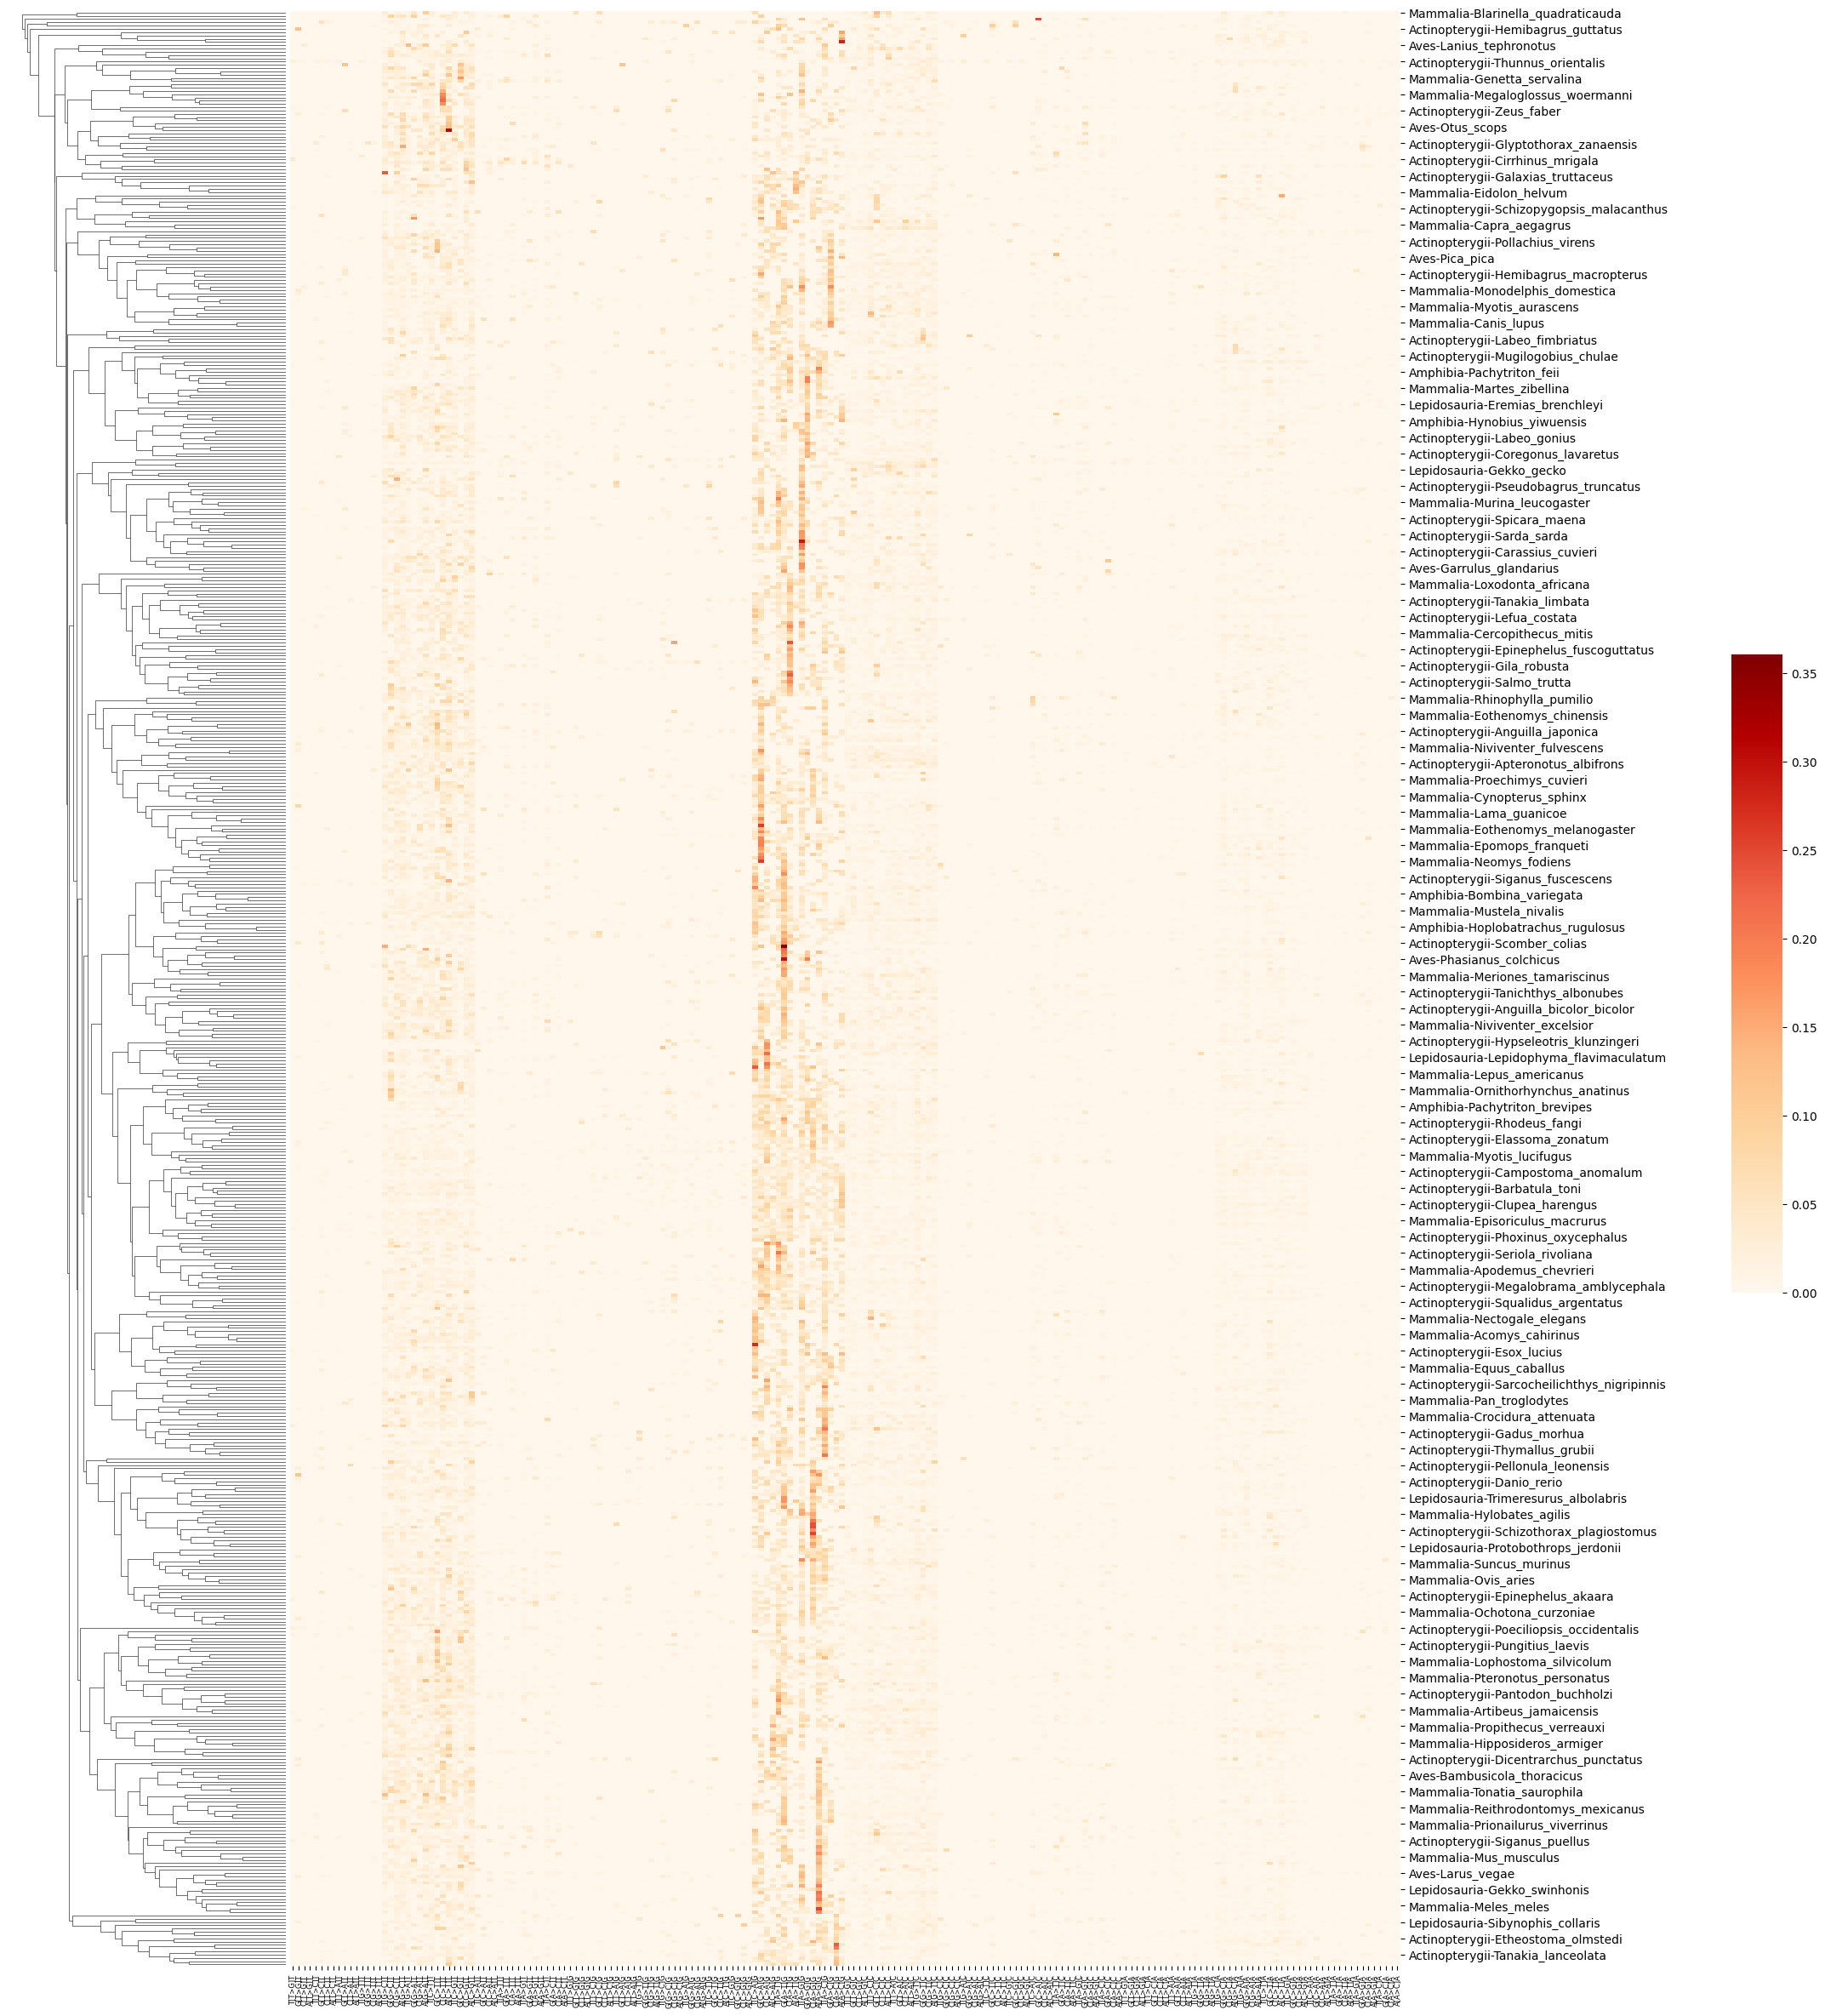

In [64]:
grd = sns.clustermap(
    data=sp2mut, 
    # pivot_kws=dict(index=["Class", "Species"], columns="Mut", values="MutSpec"), 
    col_cluster=False,
    metric=spatial.distance.cosine,
    xticklabels=mutspec.Mut.unique(),
    cmap="OrRd",
    figsize=(20, 30),
    cbar_pos=(1.02, 0.3, 0.03, 0.25),
)
grd.ax_col_dendrogram.remove()
grd.ax_heatmap.set_ylabel("")
grd.ax_heatmap.set_xlabel("")
plt.setp(grd.ax_heatmap.get_xticklabels(), size=6,)
# plt.tight_layout()
# grd.savefig("../pictures/dendromap.pdf")
plt.show()

In [5]:
df = mutspec.pivot(index=["Class", "Species"], columns="Mut", values="MutSpec")
df

Mut                                         A[A>C]A   A[A>C]C  A[A>C]G  \
Class          Species                                                   
Actinopterygii Abbottina_rivularis         0.000000  0.000000      0.0   
               Acanthopagrus_schlegelii    0.010455  0.000000      0.0   
               Acheilognathus_macropterus  0.002856  0.000000      0.0   
               Acheilognathus_rhombeus     0.000000  0.000000      0.0   
               Acheilognathus_signifer     0.006560  0.000000      0.0   
...                                             ...       ...      ...   
Mammalia       Ursus_arctos                0.000000  0.000000      0.0   
               Ursus_thibetanus            0.000000  0.000000      0.0   
               Varecia_variegata           0.000000  0.117133      0.0   
               Viverricula_indica          0.000000  0.000000      0.0   
               Vulpes_vulpes               0.000000  0.000000      0.0   

Mut                                        A[A>C]T   A[A>G]A   A[A>G]C  \
Class          Species                                                   
Actinopterygii Abbottina_rivularis             0.0  0.002474  0.000000   
               Acanthopagrus_schlegelii        0.0  0.018819  0.000000   
               Acheilognathus_macropterus      0.0  0.004422  0.005712   
               Acheilognathus_rhombeus         0.0  0.008932  0.100043   
               Acheilognathus_signifer         0.0  0.011246  0.008747   
...                                            ...       ...       ...   
Mammalia       Ursus_arctos                    0.0  0.010018  0.020036   
               Ursus_thibetanus                0.0  0.014584  0.000000   
               Varecia_variegata               0.0  0.019522  0.029283   
               Viverricula_indica              0.0  0.016102  0.000000   
               Vulpes_vulpes                   0.0  0.013834  0.000000   

Mut                                         A[A>G]G   A[A>G]T  A[A>T]A  \
Class          Species                                                   
Actinopterygii Abbottina_rivularis         0.000000  0.000000      0.0   
               Acanthopagrus_schlegelii    0.009802  0.015683      0.0   
               Acheilognathus_macropterus  0.008886  0.016502      0.0   
               Acheilognathus_rhombeus     0.004547  0.012505      0.0   
               Acheilognathus_signifer     0.009542  0.009542      0.0   
...                                             ...       ...      ...   
Mammalia       Ursus_arctos                0.030054  0.010018      0.0   
               Ursus_thibetanus            0.026250  0.021875      0.0   
               Varecia_variegata           0.026030  0.023427      0.0   
               Viverricula_indica          0.024600  0.068880      0.0   
               Vulpes_vulpes               0.011067  0.027667      0.0   

Mut                                         A[A>T]C  ...  T[T>A]G  T[T>A]T  \
Class          Species                               ...                     
Actinopterygii Abbottina_rivularis         0.014842  ...  0.00000      0.0   
               Acanthopagrus_schlegelii    0.000000  ...  0.00697      0.0   
               Acheilognathus_macropterus  0.000000  ...  0.00000      0.0   
               Acheilognathus_rhombeus     0.000000  ...  0.00000      0.0   
               Acheilognathus_signifer     0.000000  ...  0.00000      0.0   
...                                             ...  ...      ...      ...   
Mammalia       Ursus_arctos                0.000000  ...  0.00000      0.0   
               Ursus_thibetanus            0.000000  ...  0.00000      0.0   
               Varecia_variegata           0.000000  ...  0.00000      0.0   
               Viverricula_indica          0.000000  ...  0.00000      0.0   
               Vulpes_vulpes               0.000000  ...  0.00000      0.0   

Mut                                         T[T>C]A   T[T>C]C   T[T>C]G  \
Class          Specie

## Filter out transversions

In [38]:
import mutspec_utils

transitions = [x for x in mutspec_utils.constants.possible_sbs192 if x[2:5] in {"C>T", "T>C", "A>G", "G>A"}]
len(transitions)

64

In [27]:
df = df[transitions]

## Redusing dimensions

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

In [31]:
pca = PCA()
X_pca = pca.fit_transform(df)
pca.explained_variance_ratio_[:40].sum()

0.9716185192191391

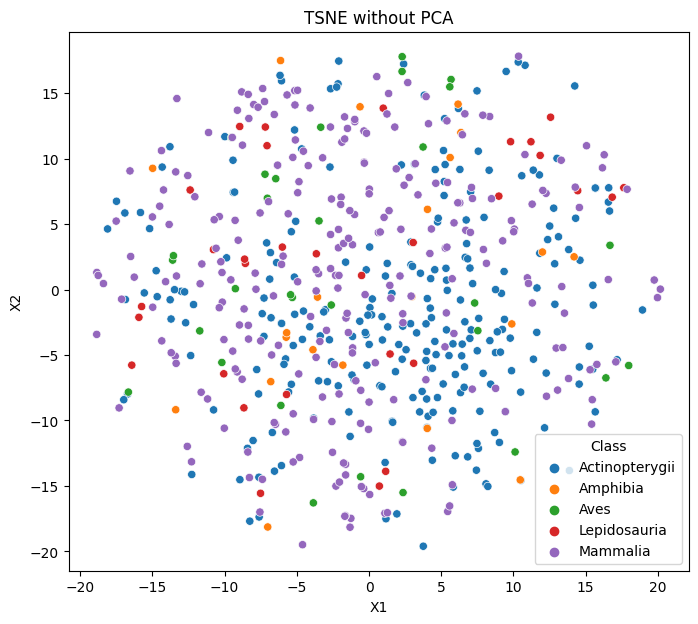

In [32]:
tsne = TSNE(2, n_jobs=12)
X_tsne = tsne.fit_transform(df)

rdf = pd.DataFrame(columns=["X1", "X2"], data=X_tsne)
rdf["Class"] = df.index.get_level_values(0)

fig, ax = plt.subplots()
fig.set_size_inches((8, 7))
sns.scatterplot(data=rdf, x="X1", y="X2", hue="Class", ax=ax)
ax.set_title("TSNE without PCA")
plt.show()

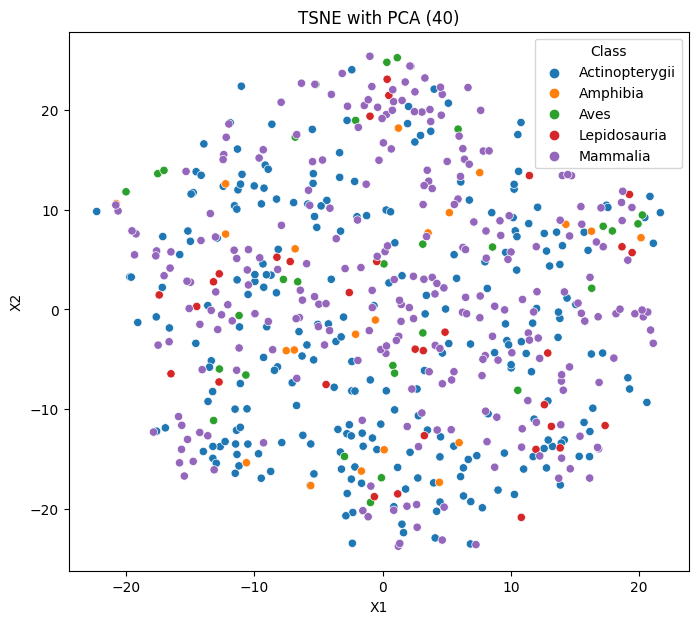

In [34]:
nfea = 40
tsne = TSNE(2, n_jobs=12, metric="cosine")
X_tsne = tsne.fit_transform(X_pca[:, :nfea])

rdf = pd.DataFrame(columns=["X1", "X2"], data=X_tsne)
rdf["Class"] = df.index.get_level_values(0)

fig, ax = plt.subplots()
fig.set_size_inches((8, 7))
sns.scatterplot(data=rdf, x="X1", y="X2", hue="Class", ax=ax)
ax.set_title(f"TSNE with PCA ({nfea})")
plt.show()

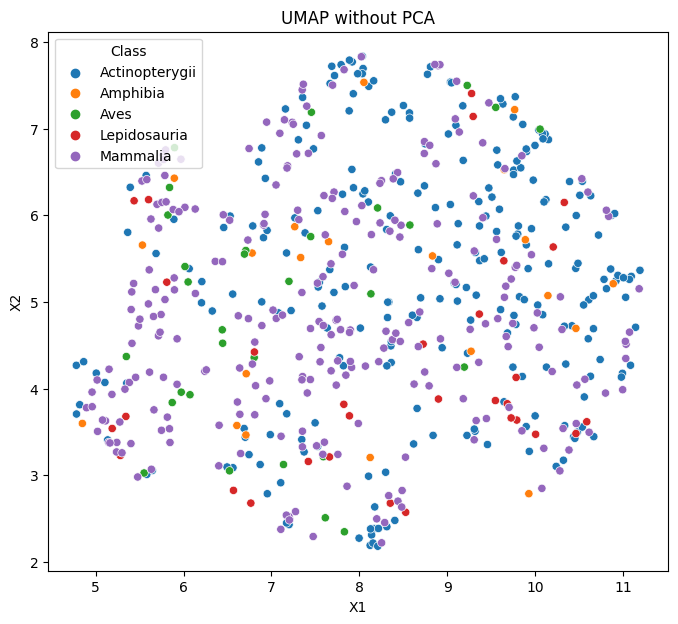

In [35]:
reducer = umap.UMAP(metric="cosine")
X_umap = reducer.fit_transform(df)

rdf = pd.DataFrame(columns=["X1", "X2"], data=X_umap)
rdf["Class"] = df.index.get_level_values(0)

fig, ax = plt.subplots()
fig.set_size_inches((8, 7))
sns.scatterplot(data=rdf, x="X1", y="X2", hue="Class", ax=ax)
ax.set_title(f"UMAP without PCA")
plt.show()

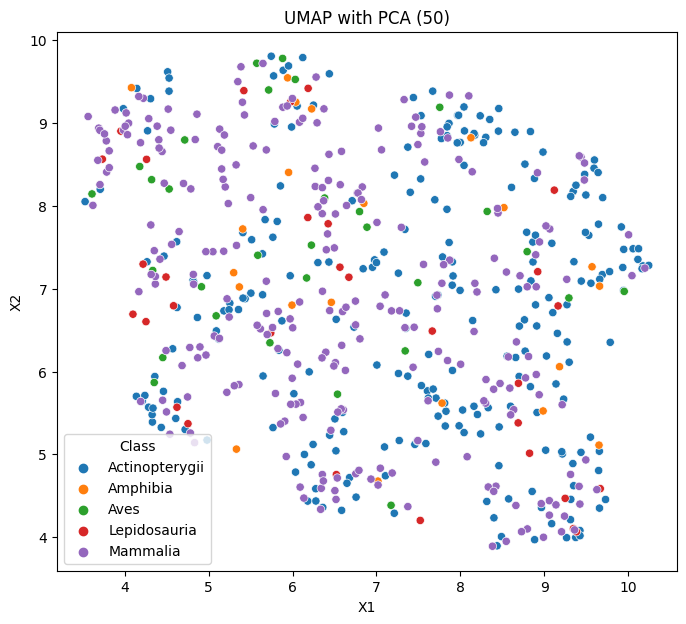

In [37]:
nfea = 50
reducer = umap.UMAP(metric="cosine")
X_umap = reducer.fit_transform(X_pca[:, :nfea])

rdf = pd.DataFrame(columns=["X1", "X2"], data=X_umap)
rdf["Class"] = df.index.get_level_values(0)

fig, ax = plt.subplots()
fig.set_size_inches((8, 7))
sns.scatterplot(data=rdf, x="X1", y="X2", hue="Class", ax=ax)
ax.set_title(f"UMAP with PCA ({nfea})")
plt.show()